In [1]:
import pandas as pd
from matplotlib.pylab import plt

# Part 1 - Exploratory Data Analysis

In [5]:
logins = pd.read_json('data/logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.index = logins.login_time
logins = logins.drop('login_time', 1)
logins['logins'] = 1
logins.head()

,logins
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [4]:
logins_15min = logins.resample('15min').count()
logins_15min.head()

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [64]:
any([x is None for x in logins_15min.logins])

False

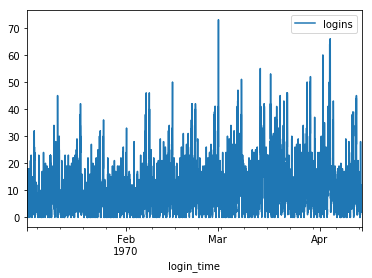

In [61]:
logins_15min.plot()
plt.show()

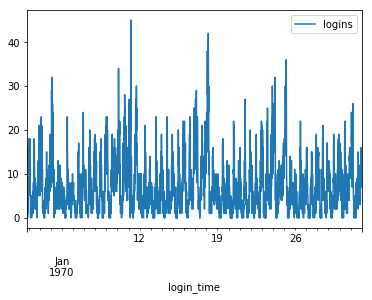

In [79]:
period = pd.Period('Jan 1970')
# logins_15min[logins_15min.index < '1970-01-05'].plot()
logins_15min[[period.start_time <= x <= period.end_time for x in logins_15min.index]].plot()
plt.show()

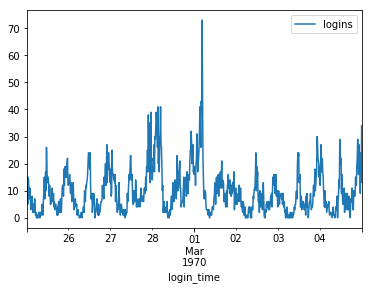

In [83]:
logins_15min[('1970-02-25' < logins_15min.index) & (logins_15min.index < '1970-03-05')].plot()
plt.show()

# Part 2 - Experiment and Metrics Design

# Part 3 - Predictive Modeling

In [255]:
# using json module because pd.read_json threw an error
import json
f = open('data/ultimate.json')
data = json.load(f)
f.close()

In [256]:
users = pd.DataFrame(data)
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [257]:
users.signup_date = pd.to_datetime(users.signup_date)
users.last_trip_date = pd.to_datetime(users.last_trip_date)

period = pd.Period('June 2014', freq='2M')
users['active'] = users.last_trip_date.apply(lambda d: period.start_time < d < period.end_time)

users = users.dropna()
users.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


In [258]:
print('{:.2f}% of all users were active'.format(100 * sum(users.active) / len(users)))

40.07% of all users were active


In [259]:
i = users.ultimate_black_user
print('{:.2f}% of the {} Ultimate Black users were active'.format(100 * sum(users.active[i]) / sum(i), sum(i)))
print('{:.2f}% of the {} regular users were active'.format(100 * sum(users.active[~i]) / sum(~i), sum(~i)))

53.86% of the 15919 Ultimate Black users were active
31.47% of the 25526 regular users were active


In [260]:
grouped = users.groupby('city')

for city in grouped.groups.keys():
    group = grouped.get_group(city)
    pct = 100 * sum(group.active) / len(group)
    print('{:.2f}% of the {} users in {} were active'.format(pct, len(group), city))

26.97% of the 13509 users in Astapor were active
64.81% of the 8775 users in King's Landing were active
37.98% of the 19161 users in Winterfell were active


In [261]:
grouped = users.groupby('phone')

for phone in grouped.groups.keys():
    group = grouped.get_group(phone)
    pct = 100 * sum(group.active) / len(group)
    print('{:.2f}% of the {} {} users were active'.format(pct, len(group), phone))

21.77% of the 12093 Android users were active
47.61% of the 29352 iPhone users were active


In [262]:
grouped = users.groupby(['city', 'phone'])

for k in grouped.groups.keys():
    group = grouped.get_group(k)
    pct = 100 * sum(group.active) / len(group)
    print('{:.2f}% of the {} {} users in {} users were active'.format(pct, len(group), k[1], k[0]))

11.43% of the 4190 Android users in Astapor users were active
33.96% of the 9319 iPhone users in Astapor users were active
45.67% of the 2104 Android users in King's Landing users were active
70.84% of the 6671 iPhone users in King's Landing users were active
20.57% of the 5799 Android users in Winterfell users were active
45.53% of the 13362 iPhone users in Winterfell users were active


In [263]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn_pandas import DataFrameMapper

In [264]:
mapper = DataFrameMapper([
    (['avg_dist'], MinMaxScaler((0, 1))),
    (['avg_rating_by_driver'], MinMaxScaler((0, 1))),
    (['avg_rating_of_driver'], MinMaxScaler((0, 1))),
    (['avg_surge'], MinMaxScaler((0, 1))),
    (['surge_pct'], MinMaxScaler((0, 1))),
    (['weekday_pct'], MinMaxScaler((0, 1))),
    ('trips_in_first_30_days', None),
    ('ultimate_black_user', None),
    ('city', LabelEncoder()),
    ('phone', LabelEncoder())
])

In [265]:
model = Pipeline([
    ('map', mapper),
    ('model', RandomForestClassifier(n_estimators=50))
])

In [266]:
kfold = StratifiedKFold(n_splits=10)
cross_val_score(model, users, users.active, cv=kfold, scoring='accuracy').mean()

0.75434906112108957